<a href="https://colab.research.google.com/github/Krishna4123/amdl/blob/main/stock_priceCb127.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Training Polynomial Model (50 epochs) for: AMZN
Epoch 0: Train MSE=35.1743, Test MSE=83.2430
Epoch 10: Train MSE=35.1743, Test MSE=83.2430
Epoch 20: Train MSE=35.1743, Test MSE=83.2430
Epoch 30: Train MSE=35.1743, Test MSE=83.2430
Epoch 40: Train MSE=35.1743, Test MSE=83.2430

Training Polynomial Model (50 epochs) for: DPZ
Epoch 0: Train MSE=1.2111, Test MSE=1.6878
Epoch 10: Train MSE=1.2111, Test MSE=1.6878
Epoch 20: Train MSE=1.2111, Test MSE=1.6878
Epoch 30: Train MSE=1.2111, Test MSE=1.6878
Epoch 40: Train MSE=1.2111, Test MSE=1.6878

Training Polynomial Model (50 epochs) for: BTC
Epoch 0: Train MSE=823.0820, Test MSE=19057.8121
Epoch 10: Train MSE=823.0820, Test MSE=19057.8121
Epoch 20: Train MSE=823.0820, Test MSE=19057.8121
Epoch 30: Train MSE=823.0820, Test MSE=19057.8121
Epoch 40: Train MSE=823.0820, Test MSE=19057.8121

Training Polynomial Model (50 epochs) for: NFLX
Epoch 0: Train MSE=1.7874, Test MSE=3.0497
Epoch 10: Train MSE=1.7874, Test MSE=3.0497
Epoch 20: Train MSE=1.

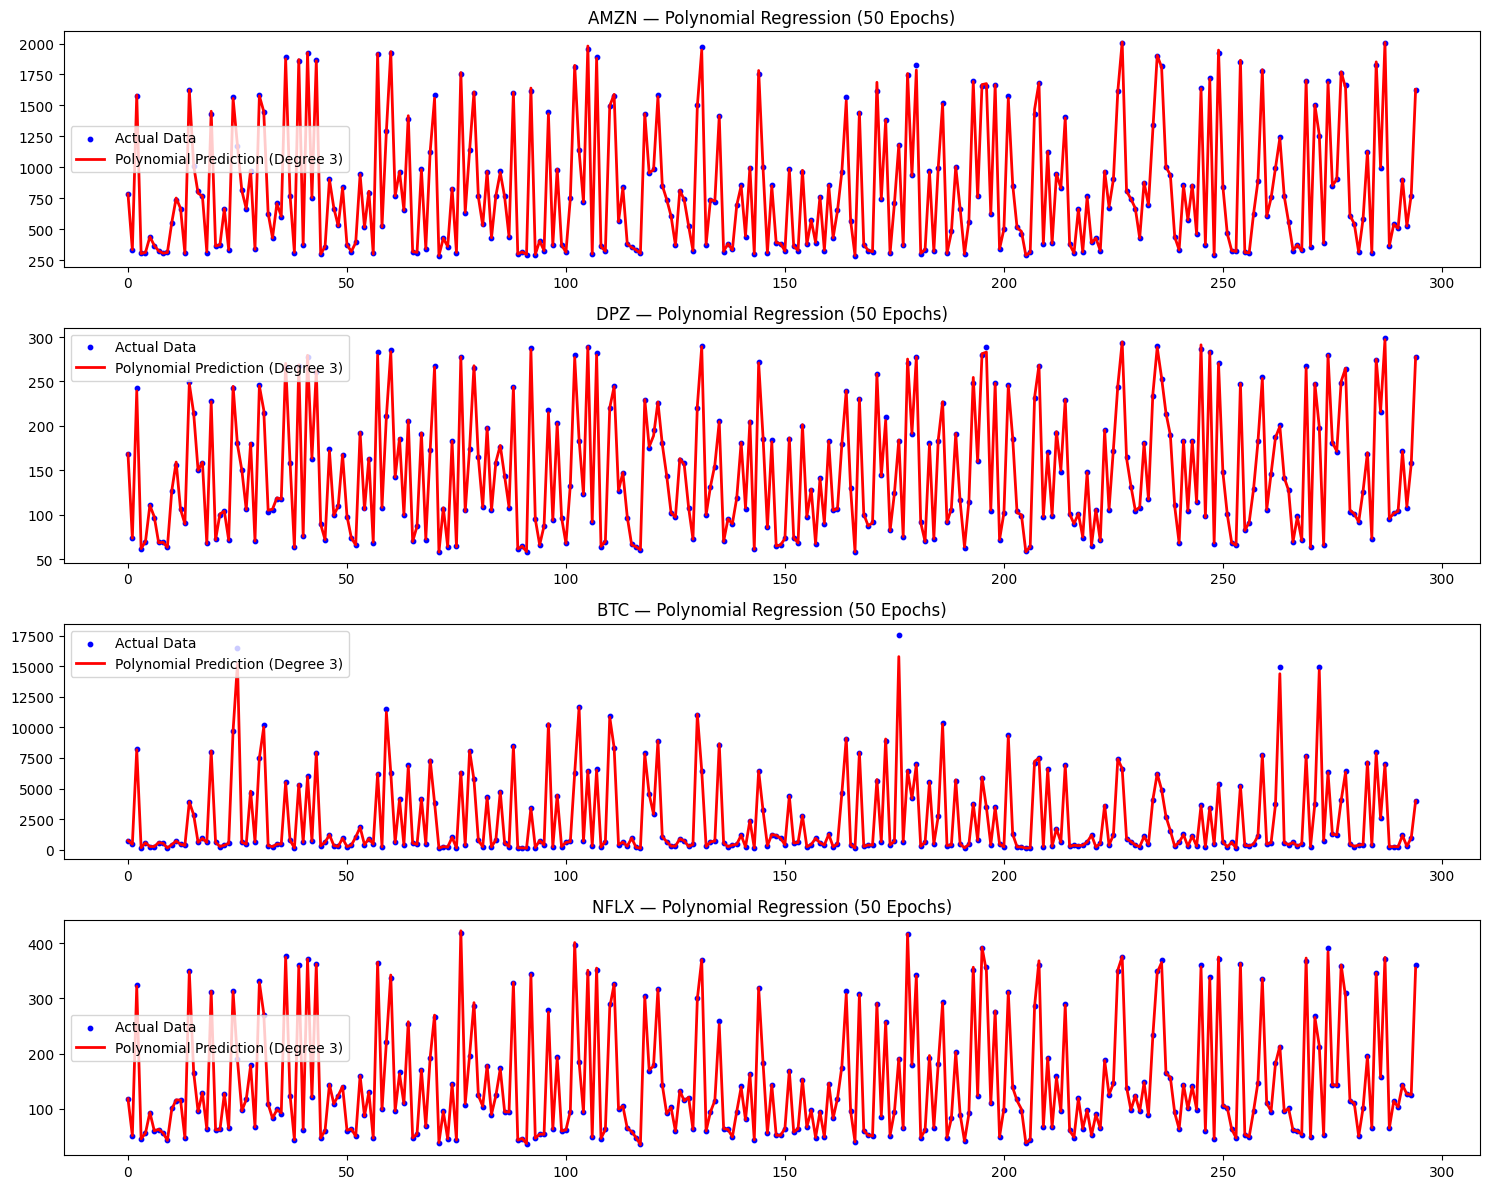


===== MODEL PERFORMANCE (POLYNOMIAL ONLY) =====
  Stock   Poly_RMSE   Poly_R2  Poly_Accuracy
0  AMZN    9.123759  0.999677       0.996599
1   DPZ    1.299168  0.999656       1.000000
2   BTC  138.050035  0.998256       1.000000
3  NFLX    1.746325  0.999726       0.982993


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score
from sklearn.model_selection import train_test_split

# Load dataset
df = pd.read_csv("portfolio_data.csv")
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date").reset_index(drop=True)

stocks = ["AMZN", "DPZ", "BTC", "NFLX"]
results = []

plt.figure(figsize=(15, 12))
plot_index = 1

# Storage for models
poly_models = {}
poly_objects = {}

for stock in stocks:

    print("\n==============================")
    print(f"Training Polynomial Model (50 epochs) for: {stock}")
    print("==============================")

    # Technical Indicators
    df[f"{stock}_ret"] = df[stock].pct_change()
    df[f"{stock}_vol"] = df[f"{stock}_ret"].rolling(window=10).std()
    df[f"{stock}_MA7"] = df[stock].rolling(window=7).mean()
    df[f"{stock}_MA20"] = df[stock].rolling(window=20).mean()
    df[f"{stock}_MA50"] = df[stock].rolling(window=50).mean()
    df[f"{stock}_momentum"] = df[stock].diff(7)
    df[f"{stock}_lag1"] = df[stock].shift(1)

    feature_cols = [
        f"{stock}_lag1",
        f"{stock}_ret",
        f"{stock}_vol",
        f"{stock}_MA7",
        f"{stock}_MA20",
        f"{stock}_MA50",
        f"{stock}_momentum",
    ]

    # Prepare clean features
    df_features = df[feature_cols].dropna()
    X = df_features.values

    # Add noise
    noise = np.random.normal(0, 0.01, X.shape)
    X = X + noise

    # Align target
    y = df[stock].iloc[-len(X):].values

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Polynomial transform
    poly = PolynomialFeatures(degree=3)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)

    poly_model = LinearRegression()

    train_losses = []
    test_losses = []

    # Epoch loop (manual)
    for epoch in range(50):
        poly_model.fit(X_train_poly, y_train)

        pred_train = poly_model.predict(X_train_poly)
        pred_test = poly_model.predict(X_test_poly)

        mse_train = mean_squared_error(y_train, pred_train)
        mse_test = mean_squared_error(y_test, pred_test)

        train_losses.append(mse_train)
        test_losses.append(mse_test)

        if epoch % 10 == 0:
            print(f"Epoch {epoch}: Train MSE={mse_train:.4f}, Test MSE={mse_test:.4f}")

    # Save model + poly object
    poly_models[stock] = poly_model
    poly_objects[stock] = poly

    # Final prediction
    poly_pred = poly_model.predict(X_test_poly)

    results.append({
        "Stock": stock,
        "Poly_RMSE": np.sqrt(mean_squared_error(y_test, poly_pred)),
        "Poly_R2": r2_score(y_test, poly_pred),
        "Poly_Accuracy": accuracy_score(np.sign(np.diff(y_test)), np.sign(np.diff(poly_pred)))
    })

    # Visualization
    plt.subplot(4, 1, plot_index)
    plt.scatter(range(len(y_test)), y_test, color="blue", s=10, label="Actual Data")
    plt.plot(range(len(poly_pred)), poly_pred, color="red", linewidth=2,
             label="Polynomial Prediction (Degree 3)")
    plt.title(f"{stock} — Polynomial Regression (50 Epochs)")
    plt.legend()
    plot_index += 1

# Show graphs
plt.tight_layout()
plt.show()

# Model performance summary
results_df = pd.DataFrame(results)
print("\n===== MODEL PERFORMANCE (POLYNOMIAL ONLY) =====")
print(results_df)


In [5]:
print("\n==============================")
print("      FUTURE PRICE PREDICTION")
print("==============================")

# Ask user for stock
user_stock = input("\nEnter stock name (AMZN / DPZ / BTC / NFLX): ").upper()

if user_stock not in stocks:
    print("❌ Invalid stock name.")
else:
    try:
        last_price = float(input(f"Enter yesterday's price for {user_stock}: "))
    except:
        print("❌ Invalid price entered.")
        exit()

    # Build final feature row
    row = [
        last_price,
        df[f"{user_stock}_ret"].iloc[-1],
        df[f"{user_stock}_vol"].iloc[-1],
        df[f"{user_stock}_MA7"].iloc[-1],
        df[f"{user_stock}_MA20"].iloc[-1],
        df[f"{user_stock}_MA50"].iloc[-1],
        df[f"{user_stock}_momentum"].iloc[-1]
    ]

    input_array = np.array(row).reshape(1, -1)

    # Get the saved polynomial transformer & model
    chosen_poly = poly_objects[user_stock]
    chosen_model = poly_models[user_stock]

    poly_input = chosen_poly.transform(input_array)
    future_price = chosen_model.predict(poly_input)[0]

    print("\n==============================")
    print(f"📈 FUTURE PRICE PREDICTION FOR {user_stock}")
    print("==============================")
    print(f"Polynomial Regression Prediction: {future_price:.2f}")
    print("==============================\n")



      FUTURE PRICE PREDICTION

Enter stock name (AMZN / DPZ / BTC / NFLX): AMZN
Enter yesterday's price for AMZN: 2300

📈 FUTURE PRICE PREDICTION FOR AMZN
Polynomial Regression Prediction: 3538.44



Before Adding few Features like Volatility,MA7......,.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    accuracy_score
)

In [ ]:
df = pd.read_csv("portfolio_data.csv")
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date").reset_index(drop=True)

stocks = ["AMZN", "DPZ", "BTC", "NFLX"]
results = []

plt.figure(figsize=(15, 12))
plot_index = 1

<Figure size 1500x1200 with 0 Axes>

In [ ]:
for stock in stocks:
    print("\n==============================")
    print(f"Training model for: {stock}")
    print("==============================")

    series = df[stock].astype(float)

    # Lag-1 feature
    X = series.shift(1).dropna().values.reshape(-1, 1)
    y = series[1:].values

    # 80-20 split
    split = int(len(X) * 0.8)
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    # -----------------------------
    # Linear Regression
    # -----------------------------
    lin_model = LinearRegression()
    lin_model.fit(X_train, y_train)
    lin_pred = lin_model.predict(X_test)

    # Metrics
    lin_mse = mean_squared_error(y_test, lin_pred)
    lin_rmse = np.sqrt(lin_mse)
    lin_mae = mean_absolute_error(y_test, lin_pred)
    lin_r2 = r2_score(y_test, lin_pred)

    # Direction accuracy (up/down)
    lin_acc = accuracy_score(
        np.sign(np.diff(y_test)),
        np.sign(np.diff(lin_pred))
    )



Training model for: AMZN

Training model for: DPZ

Training model for: BTC

Training model for: NFLX


In [ ]:
poly = PolynomialFeatures(degree=3)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

poly_model = LinearRegression()
poly_model.fit(X_train_poly, y_train)
poly_pred = poly_model.predict(X_test_poly)

    # Metrics
poly_mse = mean_squared_error(y_test, poly_pred)
poly_rmse = np.sqrt(poly_mse)
poly_mae = mean_absolute_error(y_test, poly_pred)
poly_r2 = r2_score(y_test, poly_pred)
poly_acc = accuracy_score(
    np.sign(np.diff(y_test)),
    np.sign(np.diff(poly_pred))
)

    # Save in results table
results.append({
        "Stock": stock,
        "Linear_RMSE": lin_rmse,
        "Poly_RMSE": poly_rmse,
        "Linear_R2": lin_r2,
        "Poly_R2": poly_r2,
        "Linear_Accuracy": lin_acc,
        "Poly_Accuracy": poly_acc
})

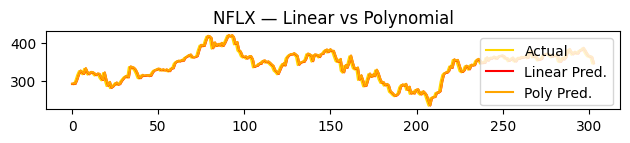

In [ ]:
plt.subplot(4, 1, plot_index)
plt.plot(y_test, label="Actual", color='gold')
plt.plot(lin_pred, label="Linear Pred.", color='red')
plt.plot(poly_pred, label="Poly Pred.", color='orange')
plt.title(f"{stock} — Linear vs Polynomial")
plt.legend()
plot_index += 1

plt.tight_layout()
plt.show()

In [ ]:
results_df = pd.DataFrame(results)
print("\n===== MODEL PERFORMANCE =====")
print(results_df)


===== MODEL PERFORMANCE =====
  Stock  Linear_RMSE  Poly_RMSE  Linear_R2   Poly_R2  Linear_Accuracy  \
0  NFLX     9.023669   9.146037   0.939928  0.938287         0.452145   

   Poly_Accuracy  
0       0.452145  


In [ ]:
print("\n==============================")
print("  FUTURE PRICE PREDICTION")
print("==============================\n")

user_stock = input("Enter stock name (AMZN / DPZ / BTC / NFLX): ").upper()

if user_stock not in stocks:
    print("Invalid stock name.")
else:
    last_price = float(input(f"Enter yesterday's price for {user_stock}: "))

    # Linear prediction
    lin_future = lin_model.predict([[last_price]])

    # Polynomial prediction
    poly_future = poly_model.predict(poly.transform([[last_price]]))

    print(f"\nPredicted next-day price of {user_stock}:")
    print(f"Linear Regression Prediction   : {lin_future[0]:.2f}")
    print(f"Polynomial Regression Prediction: {poly_future[0]:.2f}")


  FUTURE PRICE PREDICTION

Enter stock name (AMZN / DPZ / BTC / NFLX): AMZN
Enter yesterday's price for AMZN: 234

Predicted next-day price of AMZN:
Linear Regression Prediction   : 234.66
Polynomial Regression Prediction: 235.03
